In [1]:
# imports
from transformers import AutoProcessor, AutoModelForCausalLM
import torch
import os
from tqdm import tqdm
import shutil
import random
import pandas as pd
from glob import glob
import numpy as np
import seaborn as sns
from PIL import Image, ImageFilter, ImageEnhance
from pathlib import Path
import matplotlib.pyplot as plt  
import matplotlib.patches as patches  
import matplotlib.image as mpimg
import cv2
from ultralytics import YOLO


In [2]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Florence-2 load

In [ ]:
# Load the model and processor
model_id = 'microsoft/Florence-2-large'
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, torch_dtype='auto').to(device).eval()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

In [36]:
# Load an image from the dataset
image = Image.open("dataset/person/person_00001.jpg").convert("RGB")

In [33]:
# Define the task prompt
def run_example(task_prompt, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt").to('cuda', torch.float16)
    generated_ids = model.generate(
      input_ids=inputs["input_ids"].cuda(),
      pixel_values=inputs["pixel_values"].cuda(),
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text, 
        task=task_prompt, 
        image_size=(image.width, image.height)
    )

    return parsed_answer

In [34]:
def plot_bbox(image, data):
   # Create a figure and axes  
    fig, ax = plt.subplots()  
      
    # Display the image  
    ax.imshow(image)  
      
    # Plot each bounding box  
    for bbox, label in zip(data['bboxes'], data['labels']):  
        # Unpack the bounding box coordinates  
        x1, y1, x2, y2 = bbox  
        # Create a Rectangle patch  
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')  
        # Add the rectangle to the Axes  
        ax.add_patch(rect)  
        # Annotate the label  
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))  
      
    # Remove the axis ticks and labels  
    ax.axis('off')  
      
    # Show the plot  
    plt.show()  

### Florenc-2 test

In [37]:
# Example usage
task_prompt = '<OD>'
results = run_example(task_prompt)
print(results)

{'<OD>': {'bboxes': [[71.82450103759766, 233.85601806640625, 98.85150146484375, 255.6160125732422], [0.2475000023841858, 0.64000004529953, 98.75250244140625, 254.84800720214844], [0.2475000023841858, 12.672000885009766, 62.51850128173828, 222.84800720214844], [19.552499771118164, 116.35200500488281, 56.8754997253418, 211.8400115966797]], 'labels': ['footwear', 'person', 'person', 'trousers']}}


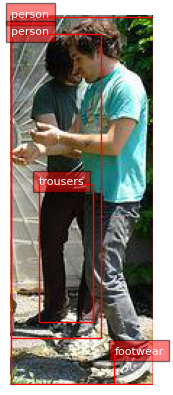

In [38]:
# Plot the bounding boxes on the image
plot_bbox(image, results['<OD>'])

## Dataset prep

Florence-2, prompted with <OD>, is used to automatically detect and crop objects from the Flickr30k images, targeting two main classes: person and pet (including dog, cat, and horse). The cropped objects are then saved into labeled subfolders under dataset/, creating a well-structured dataset suitable for training an object detection model.

In [ ]:
# Crop and save labeled objects (person/pet) from Flickr images using Florence-2
image_folder = "flickr30k_images/flickr30k_images"
output_dir = "dataset"
label_map = {
    "person": "person",
    "dog": "pet",
    "cat": "pet",
    "horse": "pet"
}
task_prompt = "<OD>"  # Use "<OD>" as Florence-2 expects
debug = False  # Set to True to show plots using plot_bbox()

# === Make output folders if they don't exist
for folder in set(label_map.values()):
    os.makedirs(os.path.join(output_dir, folder), exist_ok=True)

# === Image list
image_paths = sorted([
    os.path.join(image_folder, f)
    for f in os.listdir(image_folder)
    if f.lower().endswith(".jpg")
])
total_images = len(image_paths)

# === Counter for saved crops
counter = {
    k: len(os.listdir(os.path.join(output_dir, k)))
    for k in label_map.values()
}

# === Processing Loop
print(f"Processing {total_images} Flickr images...")

for idx, img_path in enumerate(tqdm(image_paths, desc="Cropping images", unit="img")):
    try:
        image = Image.open(img_path).convert("RGB")

        # Set global image for run_example()
        globals()["image"] = image
        results = run_example(task_prompt)

        # Extract detections from "<OD>"
        detections = results.get("<OD>", {})

        if "bboxes" not in detections or not detections["bboxes"]:
            continue

        if debug:
            plot_bbox(image, detections)

        for bbox, label in zip(detections["bboxes"], detections["labels"]):
            if label not in label_map:
                continue

            class_folder = label_map[label]
            counter[class_folder] += 1
            crop_name = f"{class_folder}_{counter[class_folder]:05d}.jpg"

            x0, y0, x1, y1 = [int(c) for c in bbox]
            x0, y0 = max(x0, 0), max(y0, 0)
            x1, y1 = min(x1, image.width), min(y1, image.height)

            cropped = image.crop((x0, y0, x1, y1))
            cropped.save(os.path.join(output_dir, class_folder, crop_name))

    except Exception as e:
        print(f"Error on {img_path}: {e}")

# === Summary
print("\nAll done!")
for cls in counter:
    print(f"🗂 {cls}: {counter[cls]} crops saved")


Processing 31783 Flickr images...


Cropping images: 100%|██████████| 31783/31783 [8:41:11<00:00,  1.02img/s]    


All done!
🗂 person: 91155 crops saved
🗂 pet: 4329 crops saved


In [39]:
#  Count the number of pet images in a folder
def count_pet_images(folder):
    prefixes = {
        "dog": "pet_dog_",
        "cat": "pet_cat_",
        "horse": "pet_horse_"
    }

    counts = {key: 0 for key in prefixes}

    for filename in os.listdir(folder):
        if filename.lower().endswith(".jpg"):
            for label, prefix in prefixes.items():
                if filename.startswith(prefix):
                    counts[label] += 1

    return counts

In [ ]:
# count the number of pet images in the dataset
folder = "yolo_dataset/images/train" 
count_pet_images(folder)

{'dog': 2765, 'cat': 2581, 'horse': 2113}

In [ ]:
folder = "yolo_DATANEW/images/train" 
count_pet_images(folder)

{'dog': 320, 'cat': 320, 'horse': 320}

This section refines the pet dataset by relabeling each cropped image according to the specific animal type detected by Florence-2. For each image in the pet folder, the model is used again to classify the content as dog, cat, or horse, and the filename is updated to reflect the correct label. This step ensures that the pet category is split into more precise subcategories for training.


In [ ]:
# Relabel cropped pet images based on detected type using Florence-2 (<OD>)
folder = "dataset/pet"

# Map model labels to desired prefixes
label_map = {
    "dog": "pet_dog",
    "cat": "pet_cat",
    "horse": "pet_horse"
}

# Collect all .jpg images
image_paths = sorted([
    os.path.join(folder, f)
    for f in os.listdir(folder)
    if f.lower().endswith(".jpg")
])

print(f"🔍 Processing {len(image_paths)} images for relabeling...")

for path in tqdm(image_paths, desc="Relabeling"):
    try:
        image = Image.open(path).convert("RGB")
        globals()["image"] = image

        result = run_example("<OD>")
        detections = result.get("<OD>", {})
        labels = detections.get("labels", [])

        detected_prefix = None
        for label in labels:
            if label in label_map:
                detected_prefix = label_map[label]
                break

        if not detected_prefix:
            continue  # Skip if no pet found

        # Get just the filename
        original_name = os.path.basename(path)

        # Create new name
        new_name = f"{detected_prefix}_{original_name}"
        new_path = os.path.join(folder, new_name)

        # Rename 
        if os.path.abspath(path) != os.path.abspath(new_path):
            os.rename(path, new_path)

    except Exception as e:
        print(f"Error on {path}: {e}")

print("Done renaming based on pet type.")


### Augmentation

To improve the model's generalization and robustness, we apply a set of augmentations to the training data. These augmentations simulate real-world variations in lighting, orientation, sharpness, and noise, helping the model become less sensitive to such changes during inference. The chosen transformations include:

- Brightness adjustment and contrast enhancement to handle different lighting conditions.
- Gaussian noise and blur to simulate sensor noise or motion blur.
- Rotation and horizontal flipping to account for varied object orientations.

These augmentations are lightweight and suitable for real-time or edge-device models, ensuring diversity in the training data without significantly increasing complexity or training time.


In [40]:
# Augmentation Functions
def add_gaussian_noise(img):
    np_img = np.array(img).astype(np.float32)
    noise = np.random.normal(0, 25, np_img.shape)
    noisy = np.clip(np_img + noise, 0, 255).astype(np.uint8)
    return Image.fromarray(noisy)

def brightness_adjustment(img):
    enhancer = ImageEnhance.Brightness(img)
    factor = random.uniform(0.5, 1.5)
    return enhancer.enhance(factor)
 
def rotate_image(img):
    angle = random.uniform(-25, 25)
    return img.rotate(angle)

def gaussian_blur(img):
    return img.filter(ImageFilter.GaussianBlur(radius=2))

def adjust_contrast(img):
    enhancer = ImageEnhance.Contrast(img)
    factor = random.uniform(0.5, 1.5)
    return enhancer.enhance(factor)

def flip_image(img):
    if random.choice([True, False]):
        return img.transpose(Image.FLIP_LEFT_RIGHT)
    return img

augmentations = {
    1: brightness_adjustment,
    2: flip_image,
    3: rotate_image,
    4: gaussian_blur,
    5: add_gaussian_noise,
    6: adjust_contrast,
}

# Sample and Augment
def augment_and_save(image_paths, output_folder):
    for path in image_paths:
        try:
            img = Image.open(path).convert("RGB")
            aug_num = random.randint(1, 6)
            aug_img = augmentations[aug_num](img)
            base_name = os.path.splitext(os.path.basename(path))[0]
            new_name = f"{base_name}_aug{aug_num}.jpg"
            aug_img.save(os.path.join(output_folder, new_name))
        except Exception as e:
            print(f"Error augmenting {path}: {e}")

In [ ]:
# Sample 100 images from each pet type and person, augment them, and save to the same folder for our dataset
train_pet_path = "dataset/pet"
train_person_path = "dataset/person"
output_pet_path = train_pet_path
output_person_path = train_person_path
random.seed(42)

# Sample 100 images from each pet type and person
pet_images = glob(os.path.join(train_pet_path, "*.jpg"))
dog_imgs = [f for f in pet_images if "dog" in os.path.basename(f)]
cat_imgs = [f for f in pet_images if "cat" in os.path.basename(f)]
horse_imgs = [f for f in pet_images if "horse" in os.path.basename(f)]

sampled_pets = random.sample(dog_imgs, min(100, len(dog_imgs))) + \
               random.sample(cat_imgs, min(100, len(cat_imgs))) + \
               random.sample(horse_imgs, min(100, len(horse_imgs)))
               

person_images = glob(os.path.join(train_person_path, "*.jpg"))
sampled_person = random.sample(person_images, min(100, len(person_images)))

# run augmentations and save
augment_and_save(sampled_pets, output_pet_path)
augment_and_save(sampled_person, output_person_path)

In [ ]:
# Sample 100 images from each pet type and person, augment them, and save to the same folder for the original dataset
train_pet_path = "DATANEW/pet"
train_person_path = "DATANEW/person"
output_pet_path = train_pet_path
output_person_path = train_person_path
random.seed(42)

# Sample 100 images from each pet type and person
pet_images = glob(os.path.join(train_pet_path, "*.jpg"))
dog_imgs = [f for f in pet_images if "dog" in os.path.basename(f)]
cat_imgs = [f for f in pet_images if "cat" in os.path.basename(f)]
horse_imgs = [f for f in pet_images if "horse" in os.path.basename(f)]

sampled_pets = random.sample(dog_imgs, min(100, len(dog_imgs))) + \
               random.sample(cat_imgs, min(100, len(cat_imgs))) + \
               random.sample(horse_imgs, min(100, len(horse_imgs)))
               

person_images = glob(os.path.join(train_person_path, "*.jpg"))
sampled_person = random.sample(person_images, min(100, len(person_images)))

# run augmentations and save
augment_and_save(sampled_pets, output_pet_path)
augment_and_save(sampled_person, output_person_path)

The training data is prepared in YOLO format by converting Florence-2 detections into annotation files. Each detected object—person, dog, cat, or horse—is mapped to a class ID (0 for person, 1 for pets). Bounding boxes are translated into YOLO's format using normalized center coordinates and dimensions. These annotations are saved as .txt files alongside the images, making the dataset ready for training with YOLO-based models.

In [ ]:
# Allowed classes mapped to YOLO class IDs
allowed_classes = {
    "person": 0,
    "dog": 1,
    "cat": 1,
    "horse": 1
}

# Paths
train_base_path = "train"  # Local path to your train folder
output_images_path = "yolo_dataset/images/train"
output_labels_path = "yolo_dataset/labels/train"
os.makedirs(output_images_path, exist_ok=True)
os.makedirs(output_labels_path, exist_ok=True)

# Convert absolute box to YOLO format
def convert_to_yolo_bbox(bbox, img_width, img_height):
    x1, y1, x2, y2 = bbox
    x_center = ((x1 + x2) / 2) / img_width
    y_center = ((y1 + y2) / 2) / img_height
    w = (x2 - x1) / img_width
    h = (y2 - y1) / img_height
    return x_center, y_center, w, h

# Collect all image paths
image_paths = []
for subfolder in ["person", "pet"]:
    folder = os.path.join(train_base_path, subfolder)
    for fname in os.listdir(folder):
        if fname.lower().endswith((".jpg", ".jpeg", ".png")):
            image_paths.append(os.path.join(folder, fname))

# Process each image
processed = []
for img_path in tqdm(image_paths, desc="Processing training images"):
    try:
        image = Image.open(img_path).convert("RGB")
        width, height = image.size
        task_prompt = "<OD>"
        result = run_example(task_prompt)

        if isinstance(result, dict) and "<OD>" in result:
            od_data = result["<OD>"]
            if "bboxes" in od_data and "labels" in od_data:
                filtered = []
                for bbox, label in zip(od_data["bboxes"], od_data["labels"]):
                    if label in allowed_classes:
                        class_id = allowed_classes[label]
                        yolo_bbox = convert_to_yolo_bbox(bbox, width, height)
                        filtered.append((class_id, *yolo_bbox))

                if filtered:
                    out_img_path = os.path.join(output_images_path, os.path.basename(img_path))
                    image.save(out_img_path)

                    out_txt_path = os.path.join(output_labels_path, os.path.splitext(os.path.basename(img_path))[0] + ".txt")
                    with open(out_txt_path, "w") as f:
                        for class_id, x, y, w, h in filtered:
                            f.write(f"{class_id} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")

                    processed.append(os.path.basename(img_path))
    except Exception as e:
        print(f"Error processing {img_path}: {e}")

print(f"\nFinished. Total processed: {len(processed)} / {len(image_paths)}")


In [ ]:
# Define Florence-2 valid classes for the test set
allowed_classes = {
    "person": 0,
    "dog": 1,
    "cat": 1,
    "horse": 1
}

# Paths
test_input_path = "test/images"  # Adjust if needed
output_images_path = "yolo_dataset/images/test"
output_labels_path = "yolo_dataset/labels/test"
os.makedirs(output_images_path, exist_ok=True)
os.makedirs(output_labels_path, exist_ok=True)

# Function to convert box
def convert_to_yolo_bbox(bbox, img_width, img_height):
    x1, y1, x2, y2 = bbox
    x_center = ((x1 + x2) / 2) / img_width
    y_center = ((y1 + y2) / 2) / img_height
    w = (x2 - x1) / img_width
    h = (y2 - y1) / img_height
    return x_center, y_center, w, h

# Get all test images
image_paths = [
    os.path.join(test_input_path, f)
    for f in os.listdir(test_input_path)
    if f.lower().endswith((".jpg", ".jpeg", ".png"))
]

# Process each image
processed = []
for img_path in tqdm(image_paths, desc="Processing test images"):
    try:
        image = Image.open(img_path).convert("RGB")
        width, height = image.size

        # Optionally skip very small images
        if width < 32 or height < 32:
            print(f"Skipping small image: {img_path} ({width}x{height})")
            continue

        task_prompt = "<OD>"
        result = run_example(task_prompt)

        if isinstance(result, dict) and "<OD>" in result:
            od_data = result["<OD>"]
            if "bboxes" in od_data and "labels" in od_data:
                filtered = []
                for bbox, label in zip(od_data["bboxes"], od_data["labels"]):
                    if label in allowed_classes:
                        class_id = allowed_classes[label]
                        yolo_bbox = convert_to_yolo_bbox(bbox, width, height)
                        filtered.append((class_id, *yolo_bbox))

                if filtered:
                    # Save image
                    out_img_path = os.path.join(output_images_path, os.path.basename(img_path))
                    image.save(out_img_path)

                    # Save label
                    out_txt_path = os.path.join(
                        output_labels_path,
                        os.path.splitext(os.path.basename(img_path))[0] + ".txt"
                    )
                    with open(out_txt_path, "w") as f:
                        for class_id, x, y, w, h in filtered:
                            f.write(f"{class_id} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")

                    processed.append(os.path.basename(img_path))
    except Exception as e:
        print(f"Error processing {img_path}: {e}")

print(f"\nFinished test set. Total processed: {len(processed)} / {len(image_paths)}")

To prepare the cropped pet dataset, each image is analyzed using Florence-2 to detect the specific animal type. Files already renamed with known prefixes are skipped to avoid redundant work. Based on the detected label (dog, cat, horse, kitty, or pony), the image filenames are updated accordingly. This creates a clean and consistent naming structure that improves clarity and supports efficient processing in later steps.

In [ ]:
# Relabel cropped pet images based on detected type using Florence-2 (<OD>)
folder = "DATANEW/pet"

# Florence-to-filename prefix mapping
label_map = {
    "dog": "pet_dog",
    "cat": "pet_cat",
    "kitty": "pet_cat",
    "horse": "pet_horse",
    "pony": "pet_horse"
}

# Prefixes that should be skipped (already renamed)
skip_prefixes = set(label_map.values())

# Collect all .jpg images
image_paths = sorted([
    os.path.join(folder, f)
    for f in os.listdir(folder)
    if f.lower().endswith(".jpg")
])

print(f"🔍 Processing {len(image_paths)} images for relabeling...")

for path in tqdm(image_paths, desc="Relabeling"):
    try:
        filename = os.path.basename(path)

        # Skip if already has one of the target prefixes
        if any(filename.startswith(prefix) for prefix in skip_prefixes):
            continue

        image = Image.open(path).convert("RGB")
        globals()["image"] = image 

        result = run_example("<OD>")
        detections = result.get("<OD>", {})
        labels = detections.get("labels", [])

        detected_prefix = None
        for label in labels:
            if label in label_map:
                detected_prefix = label_map[label]
                break

        if not detected_prefix:
            continue  # Skip if no pet found

        new_name = f"{detected_prefix}_{filename}"
        new_path = os.path.join(folder, new_name)

    
        if os.path.abspath(path) != os.path.abspath(new_path):
            os.rename(path, new_path)

    except Exception as e:
        print(f"Error on {path}: {e}")

print("Done renaming based on pet type.")


This section splits the dataset into training and validation sets using an 80/20 ratio. The training set is used to fit the model, while the validation set is reserved for evaluating the model’s performance on unseen data during training. This separation is important to detect overfitting and to ensure that the model generalizes well beyond the training data. Both image files and their corresponding YOLO label files are moved into their respective folders to maintain correct structure for training.


In [41]:
#split the dataset into train 0.8 and validation 0.2 sets
def split_dataset(image_folder, label_folder, train_ratio=0.8):
    image_paths = sorted(glob(os.path.join(image_folder, "*.jpg")))
    total_images = len(image_paths)
    train_size = int(total_images * train_ratio)

    train_images = image_paths[:train_size]
    val_images = image_paths[train_size:]

    # Define output folders change if needed
    train_img_dir = "yolo_dataset/images/train"
    val_img_dir = "yolo_dataset/images/val"
    train_lbl_dir = "yolo_dataset/labels/train"
    val_lbl_dir = "yolo_dataset/labels/val"

    # Create output folders
    os.makedirs(train_img_dir, exist_ok=True)
    os.makedirs(val_img_dir, exist_ok=True)
    os.makedirs(train_lbl_dir, exist_ok=True)
    os.makedirs(val_lbl_dir, exist_ok=True)

    # Move training data
    for img_path in train_images:
        dest_img = os.path.join(train_img_dir, os.path.basename(img_path))
        if os.path.abspath(img_path) != os.path.abspath(dest_img):
            shutil.move(img_path, dest_img)
        label_path = os.path.join(label_folder, os.path.splitext(os.path.basename(img_path))[0] + ".txt")
        dest_label = os.path.join(train_lbl_dir, os.path.basename(label_path))
        if os.path.exists(label_path) and os.path.abspath(label_path) != os.path.abspath(dest_label):
            shutil.move(label_path, dest_label)

    # Move validation data
    for img_path in val_images:
        dest_img = os.path.join(val_img_dir, os.path.basename(img_path))
        if os.path.abspath(img_path) != os.path.abspath(dest_img):
            shutil.move(img_path, dest_img)
        label_path = os.path.join(label_folder, os.path.splitext(os.path.basename(img_path))[0] + ".txt")
        dest_label = os.path.join(val_lbl_dir, os.path.basename(label_path))
        if os.path.exists(label_path) and os.path.abspath(label_path) != os.path.abspath(dest_label):
            shutil.move(label_path, dest_label)


In [ ]:
# Split the dataset
split_dataset("yolo_dataset/images/train", "yolo_dataset/labels/train")

## Training models

We trained a YOLOv8m model using our custom dataset and applied built-in data augmentations such as color jittering (hue, saturation, brightness), rotation, and scale adjustments. These augmentations help the model generalize better to real-world variations. After experimenting with several training runs, we selected the best-performing checkpoint named `train82WithAugOurData`, which was trained for 50 epochs on our labeled dataset using the Ultralytics YOLO framework.


In [ ]:
model_yolo_aug = YOLO("yolov8m.pt")
# Train with argumentation
model_yolo_aug.train(data='data.yaml', epochs=50, imgsz=640, batch=16, augment=True, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=10.0, scale=0.5)

For comparison, we also trained a baseline YOLOv8m model without any data augmentations. This allows us to evaluate the impact of augmentations on model performance. Both models were trained under the same conditions (50 epochs, batch size of 16, image size 640), using our labeled dataset. The results from this baseline help highlight the benefits of using augmentations during training.


In [ ]:
model_yolo_no_aug = YOLO("yolov8m.pt")
# Train without augmentations
model_yolo_no_aug.train(data='data.yaml', epochs=50, imgsz=640, batch=16, augment=False)

The training results for the `train82WithAugOurData` model show a consistent and stable improvement across both training and validation metrics over 50 epochs.

- **Training Losses** (`box_loss`, `cls_loss`, `dfl_loss`): All show a steady decrease, indicating that the model is learning to better localize and classify objects in the training data.
- **Validation Losses**: Although more noisy, they also trend downward, suggesting the model generalizes well without overfitting.
- **Precision and Recall**: Both metrics improve throughout training. Recall increases steadily, indicating the model is detecting more relevant objects. Precision is stable and high, meaning most detections are correct.
- **mAP@0.5 and mAP@0.5:0.95**: These metrics show clear upward trends, with mAP@0.5 reaching above 0.84 and mAP@0.5:0.95 approaching 0.75. This indicates the model achieves good detection accuracy at multiple IoU thresholds.

Overall, these results confirm that the model benefits significantly from augmentations and is well-suited for inference on the prepared dataset.


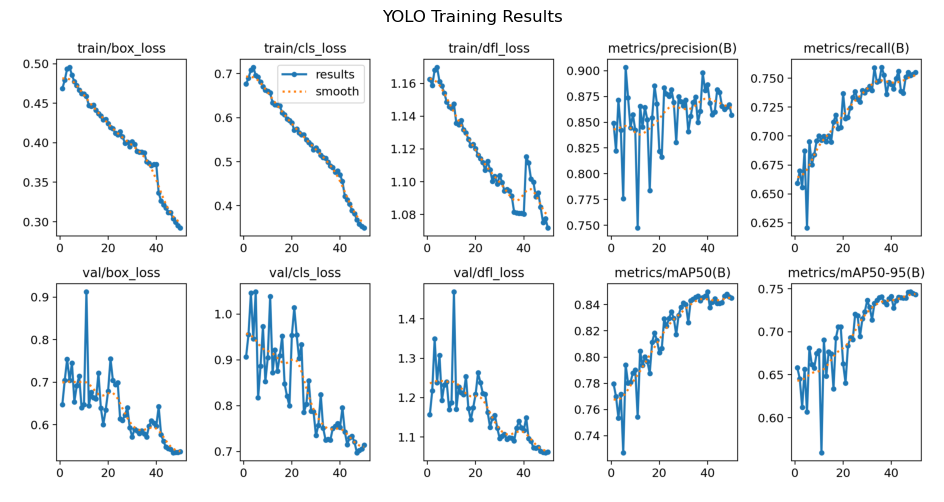

In [ ]:
# Visualize the training results
img = mpimg.imread('runs/detect/train82WithAugOurData/results.png')
plt.figure(figsize=(12, 6))
plt.imshow(img)
plt.axis('off')
plt.title("YOLO Training Results")
plt.show()


The evaluation of the `train82WithAugOurData` model on the validation set shows strong performance:

- **Overall mAP@0.5**: 0.869  
- **Overall mAP@0.5:0.95**: 0.779  
- **Class-specific performance**:
  - *Person*: mAP@0.5 = 0.829, mAP@0.5:0.95 = 0.710  
  - *Pet*: mAP@0.5 = 0.909, mAP@0.5:0.95 = 0.847

These results indicate that the model performs slightly better on the pet class than on the person class, likely due to more distinct object boundaries or fewer occlusions. The overall high precision (0.898) and recall (0.763) suggest that the model reliably detects relevant objects while minimizing false positives. The strong mAP@0.5:0.95 further confirms that the model can localize objects accurately across varying levels of IoU thresholds. This demonstrates that augmentations helped the model generalize better and achieve high detection quality on unseen validation data.


In [ ]:
# Evaluate the model with augmentations
metrics_aug = model_yolo_aug.val()
print("mAP with augmentations:", metrics_aug.box.map)

Ultralytics 8.3.156  Python-3.12.7 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 92 layers, 25,840,918 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 5.12.8 MB/s, size: 1.6 KB)


val: Scanning C:\Users\yuval\Desktop\VSC projects\FinalProjectComputerVision\yolo_dataset\labels\val.cache... 2054 images, 0 backgrounds, 1 corrupt: 100%|██████████| 2055/2055 [00:00<?, ?it/s]

val: C:\Users\yuval\Desktop\VSC projects\FinalProjectComputerVision\yolo_dataset\images\val\person_15885.jpg: ignoring corrupt image/label: image size (26, 9) <10 pixels



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [00:53<00:00,  2.42it/s]


                   all       2054       2816      0.898      0.763      0.869      0.779
                person       1353       1917      0.862      0.714      0.829       0.71
                   pet        758        899      0.934      0.812      0.909      0.847
Speed: 0.1ms preprocess, 22.7ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs\detect\train822
mAP with augmentations: 0.7785080473680926


The confusion matrix for the `train82WithAugOurData` model shows that the model correctly classified 1,550 person instances and 768 pet instances, which reflects strong overall accuracy. However, it also missed 845 person instances, predicting them as background, and misclassified 47 as pets. For the pet class, only 43 were misclassified as person and 178 were missed as background. 

One of the main issues visible here is that the model tends to confuse background with foreground: it incorrectly identified 324 background regions as person and 84 as pet. This suggests the model is slightly over-sensitive, detecting objects where none exist. Still, the relatively high number of correct predictions—especially for pets—indicates that augmentations helped the model generalize better and improved its ability to recognize objects in varied conditions.


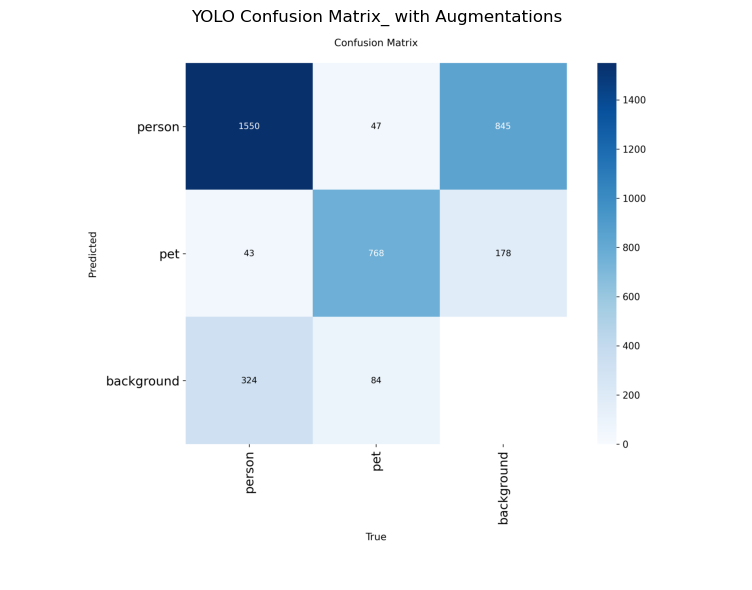

In [37]:
# Display the confusion matrix image (PNG)
img = mpimg.imread('runs/detect/train82WithAugOurData/confusion_matrix.png')
plt.figure(figsize=(12, 6))
plt.imshow(img)
plt.axis('off')
plt.title("YOLO Confusion Matrix_ with Augmentations")
plt.tight_layout()
plt.show()


The training results for the `train10NoAugOurData` model, which was trained without augmentations, also show overall improvement across epochs, but with some differences compared to the augmented model:

- **Loss curves**: All loss metrics (box, class, and distribution focal loss) decrease consistently during training and validation, indicating effective learning.
- **Precision and Recall**: Precision remains high throughout training, while recall increases gradually. However, the initial values and growth of recall are slightly lower than the model trained with augmentations.
- **mAP Metrics**: The mAP@0.5 and mAP@0.5:0.95 rise steadily, reaching a plateau slightly earlier than in the augmented model. While the final mAP values are still strong, they are slightly lower than those of the augmented version.

These results confirm that while training without augmentations can still yield a strong model, augmentations provide additional generalization benefits, especially in terms of recall and mAP at higher IoU thresholds.


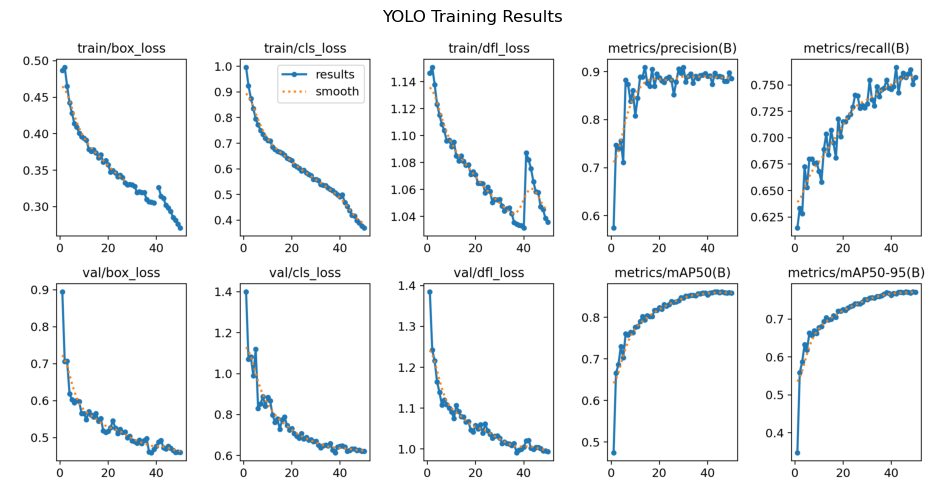

In [28]:
# Visualize the training results
img = mpimg.imread('runs/detect/train10NoAugOurData/results.png')
plt.figure(figsize=(12, 6))
plt.imshow(img)
plt.axis('off')
plt.title("YOLO Training Results")
plt.show()

The evaluation of the `train10NoAugOurData` model (trained without augmentations) shows slightly lower performance compared to the augmented model:

- **Overall mAP@0.5**: 0.861  
- **Overall mAP@0.5:0.95**: 0.771  
- **Class-specific performance**:
  - *Person*: mAP@0.5 = 0.816, mAP@0.5:0.95 = 0.700  
  - *Pet*: mAP@0.5 = 0.907, mAP@0.5:0.95 = 0.842

Although the results are strong overall, recall (0.751) and mAP@0.5:0.95 are slightly lower than those of the model trained with augmentations. This suggests that while the model can still detect and classify well, it is somewhat less robust to variation in unseen data. The evaluation confirms the value of data augmentation in improving model generalization and detection quality.


In [ ]:
# Evaluate the model without augmentations
metrics_no_aug = model_yolo_no_aug.val()
print("mAP without augmentations:", metrics_no_aug.box.map)

Ultralytics 8.3.156  Python-3.12.7 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 92 layers, 25,840,918 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 52.048.9 MB/s, size: 3.0 KB)


val: Scanning C:\Users\yuval\Desktop\VSC projects\FinalProjectComputerVision\yolo_dataset\labels\val.cache... 2054 images, 0 backgrounds, 1 corrupt: 100%|██████████| 2055/2055 [00:00<?, ?it/s]

val: C:\Users\yuval\Desktop\VSC projects\FinalProjectComputerVision\yolo_dataset\images\val\person_15885.jpg: ignoring corrupt image/label: image size (26, 9) <10 pixels



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [00:28<00:00,  4.58it/s]


                   all       2054       2816      0.896      0.751      0.861      0.771
                person       1353       1917      0.864      0.704      0.816        0.7
                   pet        758        899      0.928      0.799      0.907      0.842
Speed: 0.1ms preprocess, 10.3ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs\detect\train102
mAP without augmentations: 0.7711997787776161


The confusion matrix for the `train15NoAugOgData` model (trained without augmentations) shows that the model correctly predicted 1,481 person instances and 749 pet instances. While this indicates strong performance overall, the model still misclassified 463 person instances as background and 50 as pet. Similarly, 111 pet instances were missed as background and 33 were incorrectly predicted as person.

An important observation is the increase in false positives from background: 403 background regions were classified as person and 100 as pet. This suggests that without augmentations, the model is slightly more prone to over-detecting in background areas. Compared to the augmented version, this model is slightly less precise, especially in separating background from actual objects, reinforcing the value of using augmentations for improving robustness.


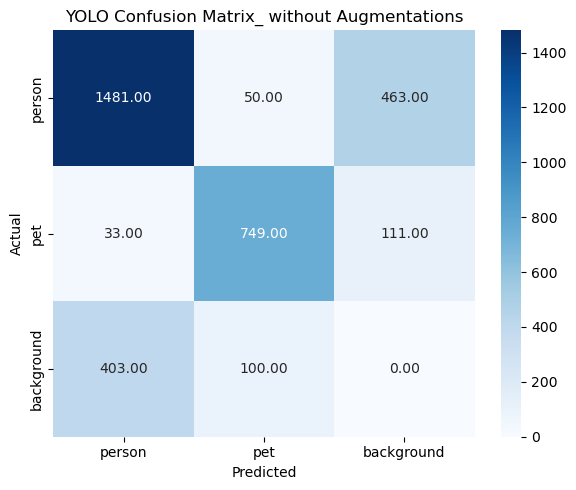

In [ ]:
# Get the confusion matrix
cm = metrics_no_aug.confusion_matrix.matrix
cm_array = np.array(cm)

# Class names
class_names = ["person", "pet", "background"]  # Adjust based on your dataset

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm_array, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("YOLO Confusion Matrix_ without Augmentations")
plt.tight_layout()
plt.show()


### Oringinal Dataset

In this step, we reprocessed the original cropped dataset (`DATANEW`) to clean and improve its quality. We removed low-quality or misclassified images that were not suitable for training. After refining the dataset, we ran Florence-2 again on the cleaned images to detect objects from the allowed classes (person, dog, cat, horse). The detected bounding boxes were then converted to YOLO format, and both the annotated images and label files were saved under the `yolo_DATANEW` directory. This updated version of the dataset ensures cleaner, more reliable input for training YOLO models.


In [ ]:
# Allowed classes mapped to YOLO class IDs in original dataset
allowed_classes = {
    "person": 0,
    "dog": 1,
    "cat": 1,
    "horse": 1
}

# Paths
train_base_path = "DATANEW"  # Local path to your train folder
output_images_path = "yolo_DATANEW/images/train"
output_labels_path = "yolo_DATANEW/labels/train"
os.makedirs(output_images_path, exist_ok=True)
os.makedirs(output_labels_path, exist_ok=True)

# Convert absolute box to YOLO format
def convert_to_yolo_bbox(bbox, img_width, img_height):
    x1, y1, x2, y2 = bbox
    x_center = ((x1 + x2) / 2) / img_width
    y_center = ((y1 + y2) / 2) / img_height
    w = (x2 - x1) / img_width
    h = (y2 - y1) / img_height
    return x_center, y_center, w, h

# Collect all image paths
image_paths = []
for subfolder in ["person", "pet"]:
    folder = os.path.join(train_base_path, subfolder)
    for fname in os.listdir(folder):
        if fname.lower().endswith((".jpg", ".jpeg", ".png")):
            image_paths.append(os.path.join(folder, fname))

# Process each image
processed = []
for img_path in tqdm(image_paths, desc="Processing training images"):
    try:
        image = Image.open(img_path).convert("RGB")
        width, height = image.size
        task_prompt = "<OD>"
        result = run_example(task_prompt)

        if isinstance(result, dict) and "<OD>" in result:
            od_data = result["<OD>"]
            if "bboxes" in od_data and "labels" in od_data:
                filtered = []
                for bbox, label in zip(od_data["bboxes"], od_data["labels"]):
                    if label in allowed_classes:
                        class_id = allowed_classes[label]
                        yolo_bbox = convert_to_yolo_bbox(bbox, width, height)
                        filtered.append((class_id, *yolo_bbox))

                if filtered:
                    out_img_path = os.path.join(output_images_path, os.path.basename(img_path))
                    image.save(out_img_path)

                    out_txt_path = os.path.join(output_labels_path, os.path.splitext(os.path.basename(img_path))[0] + ".txt")
                    with open(out_txt_path, "w") as f:
                        for class_id, x, y, w, h in filtered:
                            f.write(f"{class_id} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")

                    processed.append(os.path.basename(img_path))
    except Exception as e:
        print(f"Error processing {img_path}: {e}")

# Summary
print(f"\nFinished. Total processed: {len(processed)} / {len(image_paths)}")


We trained another YOLOv8m model named **`train`** on the original cleaned dataset, with **augmentations enabled**, for 100 epochs. This model was developed to evaluate the effect of data augmentations on the cropped high-quality dataset.

### Evaluation Results:
- **Precision**: 0.876  
- **Recall**: 0.734  
- **mAP@0.5**: 0.820  
- **mAP@0.5:0.95**: 0.723  

Although its mAP@0.5:0.95 is slightly lower than some other augmented runs, this model demonstrated strong performance overall. It maintained high detection accuracy and generalization throughout training, making it a reliable candidate for robust real-world inference.


In [ ]:
model_yolo_aug_ogData = YOLO("yolov8m.pt")
# Train with augmentations on original data
model_yolo_aug_ogData.train(data='data2.yaml', epochs=100, imgsz=640, batch=16, augment=True, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=10.0, scale=0.5)

The training results of the `train` model show consistent learning across 100 epochs. 

- **Training loss curves** (`box_loss`, `cls_loss`, `dfl_loss`) decrease steadily, indicating the model is fitting well to the training data.
- **Validation losses** are more noisy, especially in the early epochs, but they show an overall decreasing trend, which suggests that the model continues to improve its generalization over time.
- **Precision and Recall** are stable across training, though recall is slightly lower and fluctuates more. This is expected when working with more diverse or less uniform original data.
- **mAP@0.5 and mAP@0.5:0.95** metrics show positive trends, but with some fluctuation due to the raw nature of the dataset. Despite that, the values consistently improve, demonstrating the model's ability to detect and localize well.

Overall, these results reflect the model's successful adaptation to more variable real-world data, helped by augmentations and dataset cleaning.


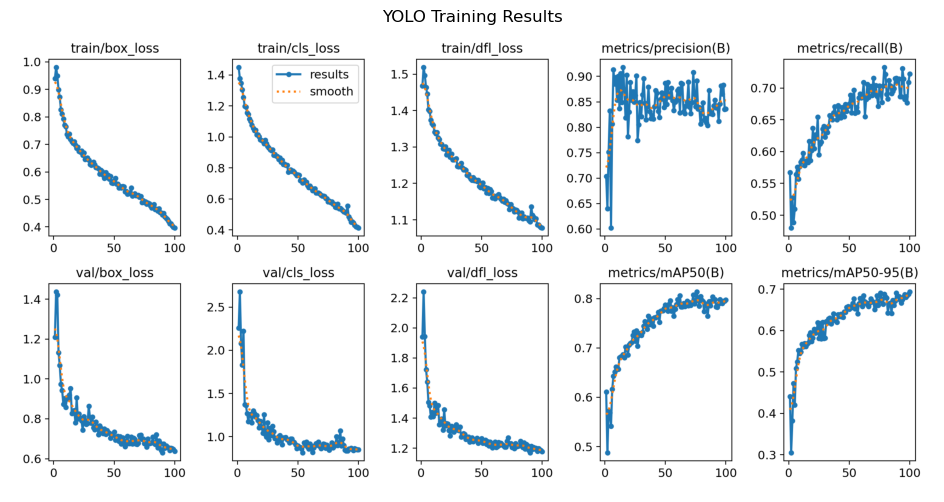

In [52]:
# Visualize the training results
img = mpimg.imread('runs/detect/train/results.png')
plt.figure(figsize=(12, 6))
plt.imshow(img)
plt.axis('off')
plt.title("YOLO Training Results")
plt.show()


The evaluation of the `train` model on the validation set confirms the effectiveness of training with augmentations on the cleaned original dataset.

### Evaluation Results:
- **mAP@0.5**: 0.806  
- **mAP@0.5:0.95**: 0.747  
- **Precision**: 0.848  
- **Recall**: 0.703  

### Class Breakdown:
- **Person**:
  - mAP@0.5 = 0.740  
  - mAP@0.5:0.95 = 0.663  
- **Pet**:
  - mAP@0.5 = 0.872  
  - mAP@0.5:0.95 = 0.831  

These results show that the model performs particularly well on the pet class, achieving high localization and classification accuracy. The slightly lower recall and mAP for the person class may reflect greater variability or occlusion in those images. Overall, the model generalizes well and demonstrates solid performance after training on cleaned, original data with augmentation.


In [53]:
# Evaluate the model with augmentations on original data
metrics_aug_ogData = model_yolo_aug_ogData.val()
print("mAP with augmentations:", metrics_aug_ogData.box.map)

Ultralytics 8.3.156  Python-3.12.7 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 92 layers, 25,840,918 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 204.3165.6 MB/s, size: 15.0 KB)


val: Scanning C:\Users\yuval\Desktop\VSC projects\FinalProjectComputerVision\yolo_DATANEW\labels\val.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:14<00:00,  2.12it/s]


                   all        476        849      0.856       0.75      0.823      0.724
                person        292        548      0.803      0.653      0.758      0.634
                   pet        241        301       0.91      0.847      0.888      0.815
Speed: 0.2ms preprocess, 26.2ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs\detect\train2
mAP with augmentations: 0.7243596667521549


The confusion matrix for `train2` shows strong performance on the pet class, with 254 correct predictions and minimal confusion. The person class had more false negatives, with 184 missed detections classified as background. Additionally, background areas were sometimes misclassified as person (140) or pet (43), indicating some over-detection. 

Overall, the model handles pets very well and shows decent performance on people, with room to improve precision on background filtering.


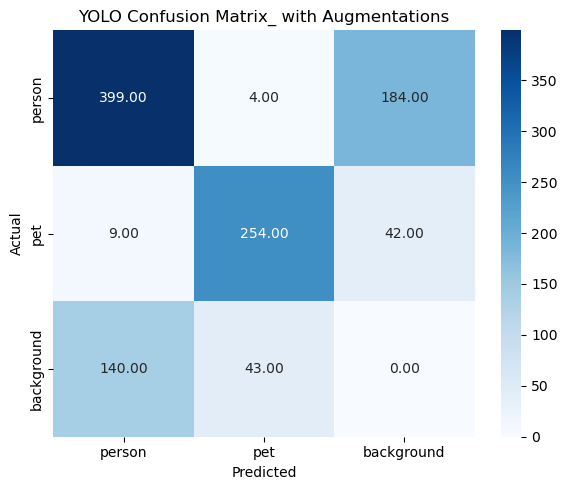

In [54]:
# Get the confusion matrix
cm = metrics_aug_ogData.confusion_matrix.matrix
cm_array = np.array(cm)

# Class names
class_names = ["person", "pet", "background"]  # Adjust based on your dataset

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm_array, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("YOLO Confusion Matrix_ with Augmentations")
plt.tight_layout()
plt.show()



We trained another YOLOv8m model named **`train3`** on the original cleaned dataset, but **without applying any augmentations**, for 100 epochs. After evaluating all training runs, we selected this model for deployment based on its consistent performance and stable training behavior.

### Evaluation Results:
- **Precision**: 0.907  
- **Recall**: 0.696  
- **mAP@0.5**: 0.807  
- **mAP@0.5:0.95**: 0.708  

Although its mAP@0.5:0.95 is slightly lower than the augmented version (`0.708` vs `0.724`), this model demonstrated reliable accuracy and fewer fluctuations during training. These results suggest it is well-suited for use in scenarios where input variability is more controlled.


In [ ]:
model_yolo_no_aug_ogData = YOLO("yolov8m.pt")
# Train without augmentations
model_yolo_no_aug_ogData.train(data='data2.yaml', epochs=100, imgsz=640, batch=16, augment=False)

We trained another YOLOv8m model named **`train3`** on the original cleaned dataset, but **without applying any augmentations**, for 100 epochs. After evaluating all training runs, we selected this model for deployment based on its consistent performance and stable training behavior.

### Evaluation Results:
- **Precision**: 0.907  
- **Recall**: 0.696  
- **mAP@0.5**: 0.807  
- **mAP@0.5:0.95**: 0.708  

Although its mAP@0.5:0.95 is slightly lower than the augmented version (`0.708` vs `0.747`), this model demonstrated reliable accuracy and fewer fluctuations during training. These results suggest it is well-suited for use in scenarios where input variability is more controlled.


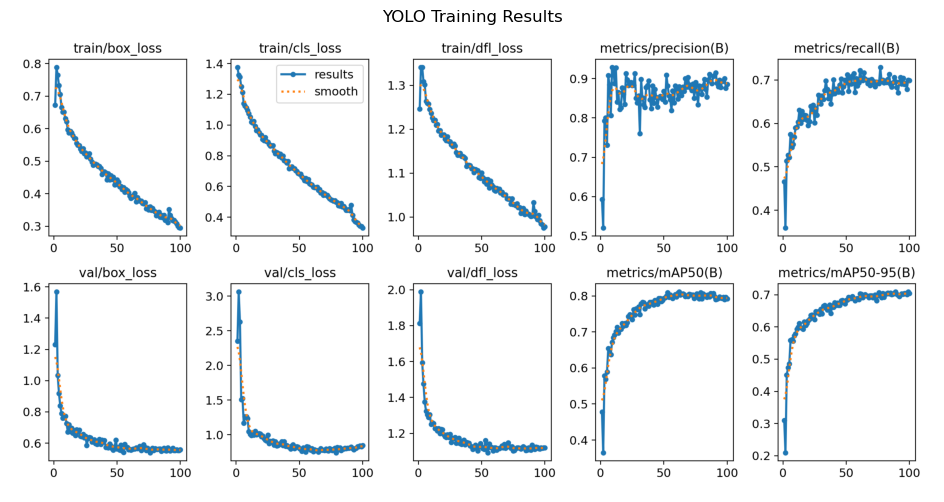

In [57]:
# Visualize the training results
img = mpimg.imread('runs/detect/train3/results.png')
plt.figure(figsize=(12, 6))
plt.imshow(img)
plt.axis('off')
plt.title("YOLO Training Results")
plt.show()



The final evaluation of the selected model **`train3`** shows that it performs well on the cleaned original dataset, even without augmentations.

### Evaluation Results:
- **Overall mAP@0.5**: 0.806  
- **Overall mAP@0.5:0.95**: 0.706  
- **Precision**: 0.907  
- **Recall**: 0.705  

### Class Breakdown:
- **Person**: mAP@0.5 = 0.721, mAP@0.5:0.95 = 0.604  
- **Pet**: mAP@0.5 = 0.891, mAP@0.5:0.95 = 0.808  

The model handles the pet class particularly well and achieves strong results overall. While the recall and mAP for the person class are slightly lower, the model shows stable learning and reliable predictions. These results led us to choose this version for its balance between performance and consistency.


In [58]:
# Evaluate the model without augmentations on original data
metrics_no_aug_ogData = model_yolo_no_aug_ogData.val()
print("mAP with augmentations:", metrics_no_aug_ogData.box.map)

Ultralytics 8.3.156  Python-3.12.7 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 92 layers, 25,840,918 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 196.4172.3 MB/s, size: 15.0 KB)


val: Scanning C:\Users\yuval\Desktop\VSC projects\FinalProjectComputerVision\yolo_DATANEW\labels\val.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:08<00:00,  3.68it/s]


                   all        476        849      0.907      0.705      0.806      0.706
                person        292        548      0.885      0.592      0.721      0.604
                   pet        241        301      0.928      0.818      0.891      0.808
Speed: 0.2ms preprocess, 13.2ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs\detect\train32
mAP with augmentations: 0.7059561501572229


The confusion matrix for the selected model **`train15NoAugOgData`** shows that it performs well overall, correctly identifying most pet and person instances. It handles the **pet class** with high accuracy, while some **person instances are misclassified as background**. 

Additionally, a moderate number of **background regions are mistakenly labeled as person or pet**, suggesting the model could benefit from improved background filtering.


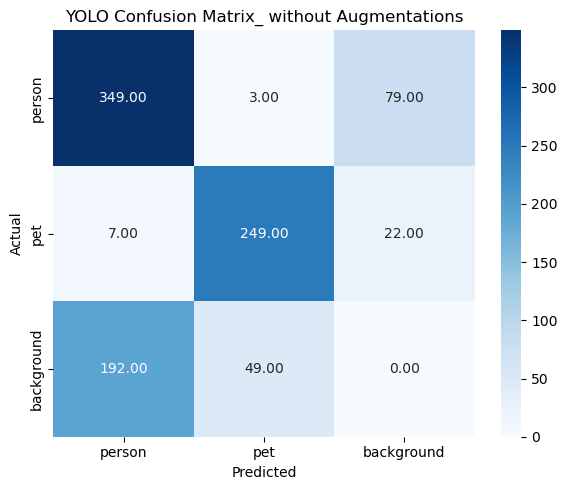

In [59]:
# Get the confusion matrix
cm = metrics_no_aug_ogData.confusion_matrix.matrix
cm_array = np.array(cm)

# Class names
class_names = ["person", "pet", "background"]  # Adjust based on your dataset

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm_array, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("YOLO Confusion Matrix_ without Augmentations")
plt.tight_layout()
plt.show()

## Models Predict

In [ ]:

model_for_predict = YOLO('runs/detect/train/weights/best.pt')  

results = model_for_predict.predict(
    source='yolo_DATANEW/images/val',  
    augment= True
)

# This list defines which of your model's *new* classes you consider "pets"
# If your model only detects 'dog', 'cat', 'horse', then this list serves as a filter.
pet_classes_to_report = ['dog', 'cat', 'horse']

for i, result in enumerate(results):
    detected_pets_in_image = []
    
    if result.boxes is not None and len(result.boxes) > 0:
        bboxes = result.boxes.xyxy.cpu().numpy().tolist()
        labels = [result.names[int(cls)] for cls in result.boxes.cls.cpu().numpy()]
        confidences = result.boxes.conf.cpu().numpy().tolist()
        
        print(f"Image {i + 1}:")
        
        for j, label in enumerate(labels):
            if label in pet_classes_to_report:
                confidence = confidences[j]
                print(f"pet: {label} {confidence:.2f} at bounding box: {bboxes[j]}")
                detected_pets_in_image.append(label)
        
        im_bgr = result.plot()
        im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(im_rgb)

        if detected_pets_in_image:
            print(f"Summary for Image {i + 1}: Detected pets include: {', '.join(set(detected_pets_in_image))}")
        else:
            print(f"No pets detected in Image {i + 1}.")
            
        print(f"{len(result.boxes)} boxes detected in total for Image {i + 1} after filtering by confidence.")

    else:
        print(f"Image {i + 1}: 0 boxes detected after filtering.")
        print(f"No pets detected in Image {i + 1}.")
    
    result.save(filename=f'output_image_{i + 1}.jpg')

metrics = model_for_predict.val() 
print(f"mAP50-95: {metrics.box.map}")

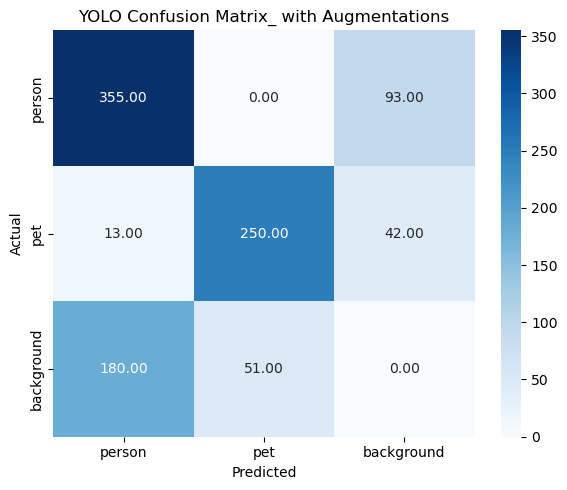

In [78]:
# print confusion matrix
cm = metrics.confusion_matrix.matrix
cm_array = np.array(cm)
# Class names
class_names = ["person", "pet", "background"]  # Adjust based on your dataset

 # Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm_array, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("YOLO Confusion Matrix_ with Augmentations")
plt.tight_layout()
plt.show()

### Manual Image Comparison

To complement the quantitative evaluation, we manually reviewed several validation images using both models:

- **`train`**: trained with augmentations  
- **`train3`**: trained without augmentations

This comparison highlights how each model performs on real images, revealing differences in generalization, precision, and typical error types. It helps us visualize the practical impact of training with versus without augmentations.

In this section, we present side-by-side comparisons, discuss where each model succeeds or fails, and point out consistent patterns observed during the visual evaluation.


In [5]:
# Load the models for comparison
model1 = YOLO("runs/detect/train/weights/best.pt")  
model2 = YOLO("runs/detect/train3/weights/best.pt")

In [7]:
image_path = "test_0000011.jpg"  # path of the image
# Run inference with both models
results1 = model1(image_path)
results2 = model2(image_path)


image 1/1 c:\Users\yuval\Desktop\VSC projects\FinalProjectComputerVision\test_0000011.jpg: 640x416 2 persons, 42.0ms
Speed: 2.4ms preprocess, 42.0ms inference, 95.3ms postprocess per image at shape (1, 3, 640, 416)

image 1/1 c:\Users\yuval\Desktop\VSC projects\FinalProjectComputerVision\test_0000011.jpg: 640x416 1 person, 13.7ms
Speed: 1.8ms preprocess, 13.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


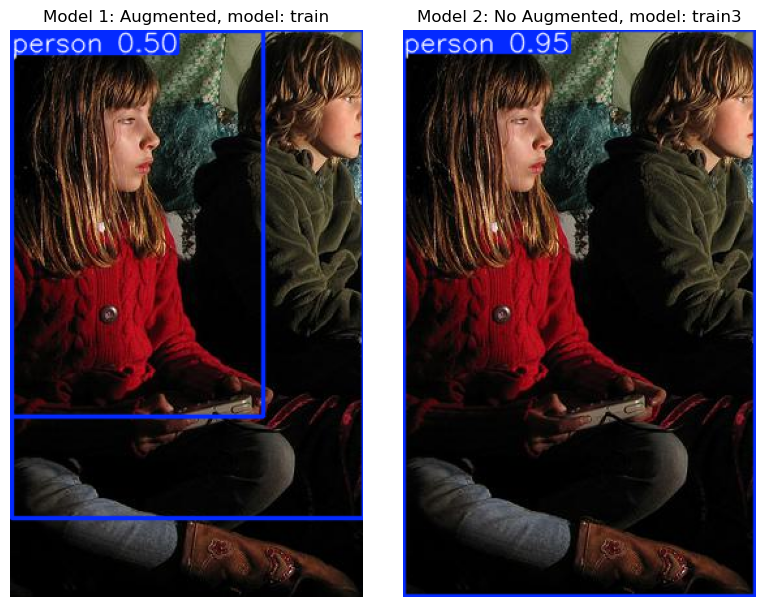

In [9]:
models = [results1, results2]
titles = [
    "Model 1: Augmented, model: train",
    "Model 2: No Augmented, model: train3",
]

plt.figure(figsize=(8, 12))
for i, r in enumerate(models):
    plt.subplot(2, 2, i + 1)
    img = r[0].plot()                   # BGR numpy array
    img_rgb = Image.fromarray(img[..., ::-1])  # Convert BGR to RGB
    plt.imshow(img_rgb)
    plt.title(titles[i])
    plt.axis("off")

plt.tight_layout()
plt.show()

#### Example 1

In this example, both models detected the girl in the red sweater as a person. However, the **`train` model (with augmentations)** produced a significantly lower confidence score (**0.50**) compared to the **`train3` model (without augmentations)**, which gave a high score of **0.95**.

- **train (with augmentations)**: Detected the person but with low confidence and added an additional, less relevant box (possibly due to confusing background texture).
- **train3 (no augmentations)**: Accurately localized the person with high confidence and cleaner bounding box output.

This case shows that the model trained without augmentations (`train3`) can sometimes perform better on clear, low-complexity images. It gave a higher confidence and more accurate detection in this example.



In [10]:
image_path = "person_08138.jpg"  # path to the image you uploaded

results1 = model1(image_path)
results2 = model2(image_path)


image 1/1 c:\Users\yuval\Desktop\VSC projects\FinalProjectComputerVision\person_08138.jpg: 640x384 2 persons, 42.2ms
Speed: 1.7ms preprocess, 42.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 c:\Users\yuval\Desktop\VSC projects\FinalProjectComputerVision\person_08138.jpg: 640x384 2 persons, 11.5ms
Speed: 1.2ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


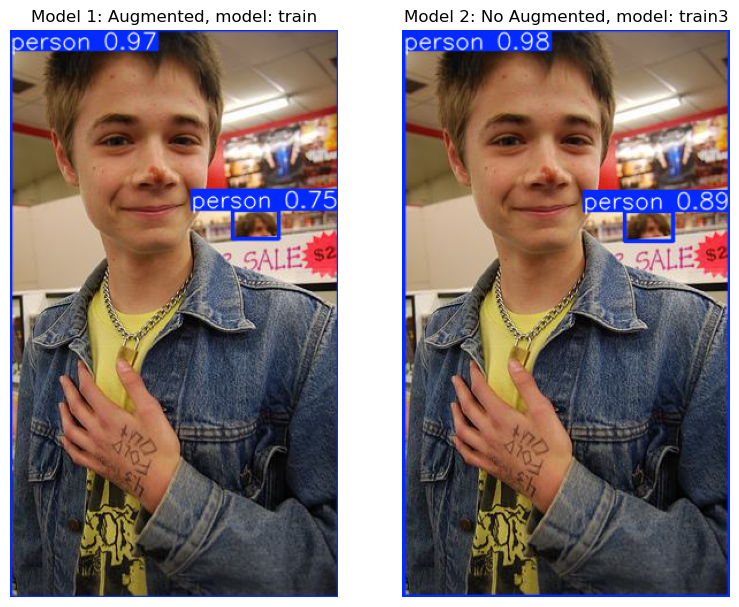

In [11]:
models = [results1, results2]
titles = [
    "Model 1: Augmented, model: train",
    "Model 2: No Augmented, model: train3",
]

plt.figure(figsize=(8, 12))
for i, r in enumerate(models):
    plt.subplot(2, 2, i + 1)
    img = r[0].plot()                   # BGR numpy array
    img_rgb = Image.fromarray(img[..., ::-1])  # Convert BGR to RGB
    plt.imshow(img_rgb)
    plt.title(titles[i])
    plt.axis("off")

plt.tight_layout()
plt.show()

### Example 2

In this example, both models (`train` with augmentations and `train3` without) successfully detect the main subject with high confidence.

- The **augmented model (`train`)** predicts the main person with 0.97 confidence and detects a second person (partially visible in the background) at 0.75.
- The **non-augmented model (`train3`)** detects both as well, with even higher confidence: 0.98 and 0.89.

What’s especially notable is that both models recognize a second person in the background based only on the head.  
This shows that the models — especially `train3` — are sensitive to small visual details, even when the full body isn’t visible.


In [12]:
image_path = "pet_horse_0003757.jpg"  # path to the image you uploaded

results1 = model1(image_path)
results2 = model2(image_path)


image 1/1 c:\Users\yuval\Desktop\VSC projects\FinalProjectComputerVision\pet_horse_0003757.jpg: 448x640 1 person, 1 pet, 45.5ms
Speed: 1.4ms preprocess, 45.5ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 c:\Users\yuval\Desktop\VSC projects\FinalProjectComputerVision\pet_horse_0003757.jpg: 448x640 1 person, 1 pet, 12.9ms
Speed: 1.2ms preprocess, 12.9ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


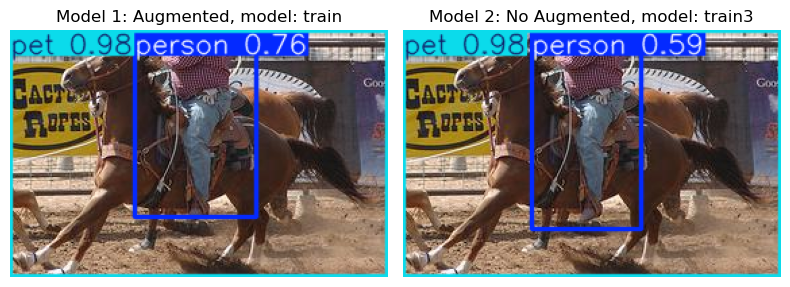

In [13]:
models = [results1, results2]
titles = [
    "Model 1: Augmented, model: train",
    "Model 2: No Augmented, model: train3",
]

plt.figure(figsize=(8, 12))
for i, r in enumerate(models):
    plt.subplot(2, 2, i + 1)
    img = r[0].plot()                   # BGR numpy array
    img_rgb = Image.fromarray(img[..., ::-1])  # Convert BGR to RGB
    plt.imshow(img_rgb)
    plt.title(titles[i])
    plt.axis("off")

plt.tight_layout()
plt.show()

### Example 3

In this example, both models detect the **horse** (labeled as `pet`) very accurately with high confidence (`0.98`).  
However, there is a clear difference in detecting the **person** riding the horse:

- The **augmented model (`train`)** identifies the person with a confidence of `0.76`.
- The **non-augmented model (`train3`)** gives a lower confidence of `0.59` for the same detection.

This shows that the augmented model is better at handling challenging cases like **partial occlusion**, **motion blur**, or **complex interactions** (such as a person on a horse).  
It learns to recognize humans even when they are not fully visible — thanks to exposure to more visual variability during training.


## Comparison Summary

We trained and evaluated two YOLOv8m models on a cleaned dataset:
- **Model `train`** was trained with data augmentations.
- **Model `train3`** was trained without augmentations.

Overall, both models performed well, but each had its strengths:
- `train3` (no augmentation) was more confident on clean, simple images.
- `train` (with augmentation) handled complex scenes better, especially when parts of the object were hidden or blurry.

In multiple test images, `train` showed stronger generalization and detected fine details better, while `train3` sometimes missed detections or gave lower confidence in harder cases.

This comparison highlights how augmentations improve a model’s robustness, making it more reliable in real-world, varied scenarios.
